# Data Exploration - Working


---


**Mentor:**
  - ***Professor Richard Sowers***, Department of Industrial and Systems Engineering, University of Illinois at Urbana-Champaign (UIUC).

**Group Members:**
  - ***Advika Pattiwar*** (linkedin.com/in/advika-pattiwar)
  - ***Dhruv Borda*** (linkedin.com/thebordadhruv)
  - ***Hrithik Rathi*** (linkedin.com/in/hrithik-rathi)
  - ***Suvrata Gayathri Kappagantula*** (linkedin.com/in/gayathrikappagantula)


---


This notebook is designed to comprehensively explore the dataset with the following objectives:

**Primary Goals:**
1. **Data Visualization**:
   - Visualize data distributions and relationships.
   - Identify patterns and insights that can guide further analysis.

2. **Descriptive Statistics**:
   - Calculate basic statistics to understand dataset characteristics.
   - Examine distributions, central tendencies, and variability of data.

3. **Bias Examination**:
   - Identify and analyze any biases in labels.
   - Understand how these biases may affect model performance.

4. **Data Quality and Sparsity**:
   - Address missing data and assess data completeness.
   - Handle imbalanced or sparse data, ensuring robustness of the model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import io
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.nonparametric.smoothers_lowess import lowess

### Access data from AWS s3 bucket

In [3]:
# Load the data from the URL
url = "https://s3-us-east-2.amazonaws.com/dhruvborda-project-nyccitibikerentals/Dataset/working.pkl"
response = requests.get(url)

if response.status_code == 200:
    working = pd.read_pickle(io.BytesIO(response.content))
    working_backup = working.copy()
    print("Data loaded successfully.")
else:
    print(f"Failed to download working.pkl. Status code: {response.status_code}")
    exit()  # Exit if data loading fails

Data loaded successfully.


### 1. Visualize the data to gain insights and identify patterns.
### 2. Calculate descriptive statistics to understand the dataset's characteristics.

In [4]:
trips_by_date = working.groupby('date').size().reset_index(name='number_of_trips')
trips_by_date.sort_values(by="date", inplace=True)

trips_by_date['year'] = trips_by_date['date'].dt.year
trips_by_date['month'] = trips_by_date['date'].dt.month
trips_by_date['week'] = trips_by_date['date'].dt.isocalendar().week
trips_by_date['day'] = trips_by_date['date'].dt.day
trips_by_date['weekday'] = trips_by_date['date'].dt.weekday
trips_by_date['weekday_name'] = trips_by_date['date'].dt.day_name()

fig = go.Figure()


fig.add_trace(go.Scatter(x=trips_by_date["date"],
                         y=trips_by_date["number_of_trips"],
                         mode='markers',
                         marker=dict(size=3, color="black"),
                         name='Daily Trips'))

# Fit a polynomial of degree 2 (quadratic) to the data
coefficients = np.polyfit(trips_by_date["date"].index, trips_by_date["number_of_trips"], 10)
polynomial = np.poly1d(coefficients)
y_polynomial = polynomial(trips_by_date["date"].index)

fig.add_trace(go.Scatter(x=trips_by_date["date"],
                         y=y_polynomial,
                         mode='lines',
                         line_color='red',
                         name='Polynomial Trendline'))


loess_result = lowess(trips_by_date['number_of_trips'],
                      trips_by_date['date'].astype(np.int64),
                      frac=0.1)

dates_loess = pd.to_datetime(loess_result[:, 0], unit='ns')
number_of_trips_loess = loess_result[:, 1]


# Add the LOESS smoothed trendline to the plot
fig.add_trace(go.Scatter(x=dates_loess,
                         y=number_of_trips_loess,
                         mode='lines',
                         line=dict(color='blue', width=2),
                         name='LOESS Trendline'))

# Update plot layout with titles and axes labels as needed
fig.update_layout(
    title="Citi Bike Daily Trips with Polynomial and LOESS Trendlines",
    xaxis_title="Date",
    yaxis_title="Number of Trips"
)

fig.show()

# Save the figure to Google Drive
fig.write_html('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Data Exploration Working/Citi Bike Daily Trips with Polynomial and LOESS Trendlines.html')

<ipython-input-5-5105c25ddc36>:34: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



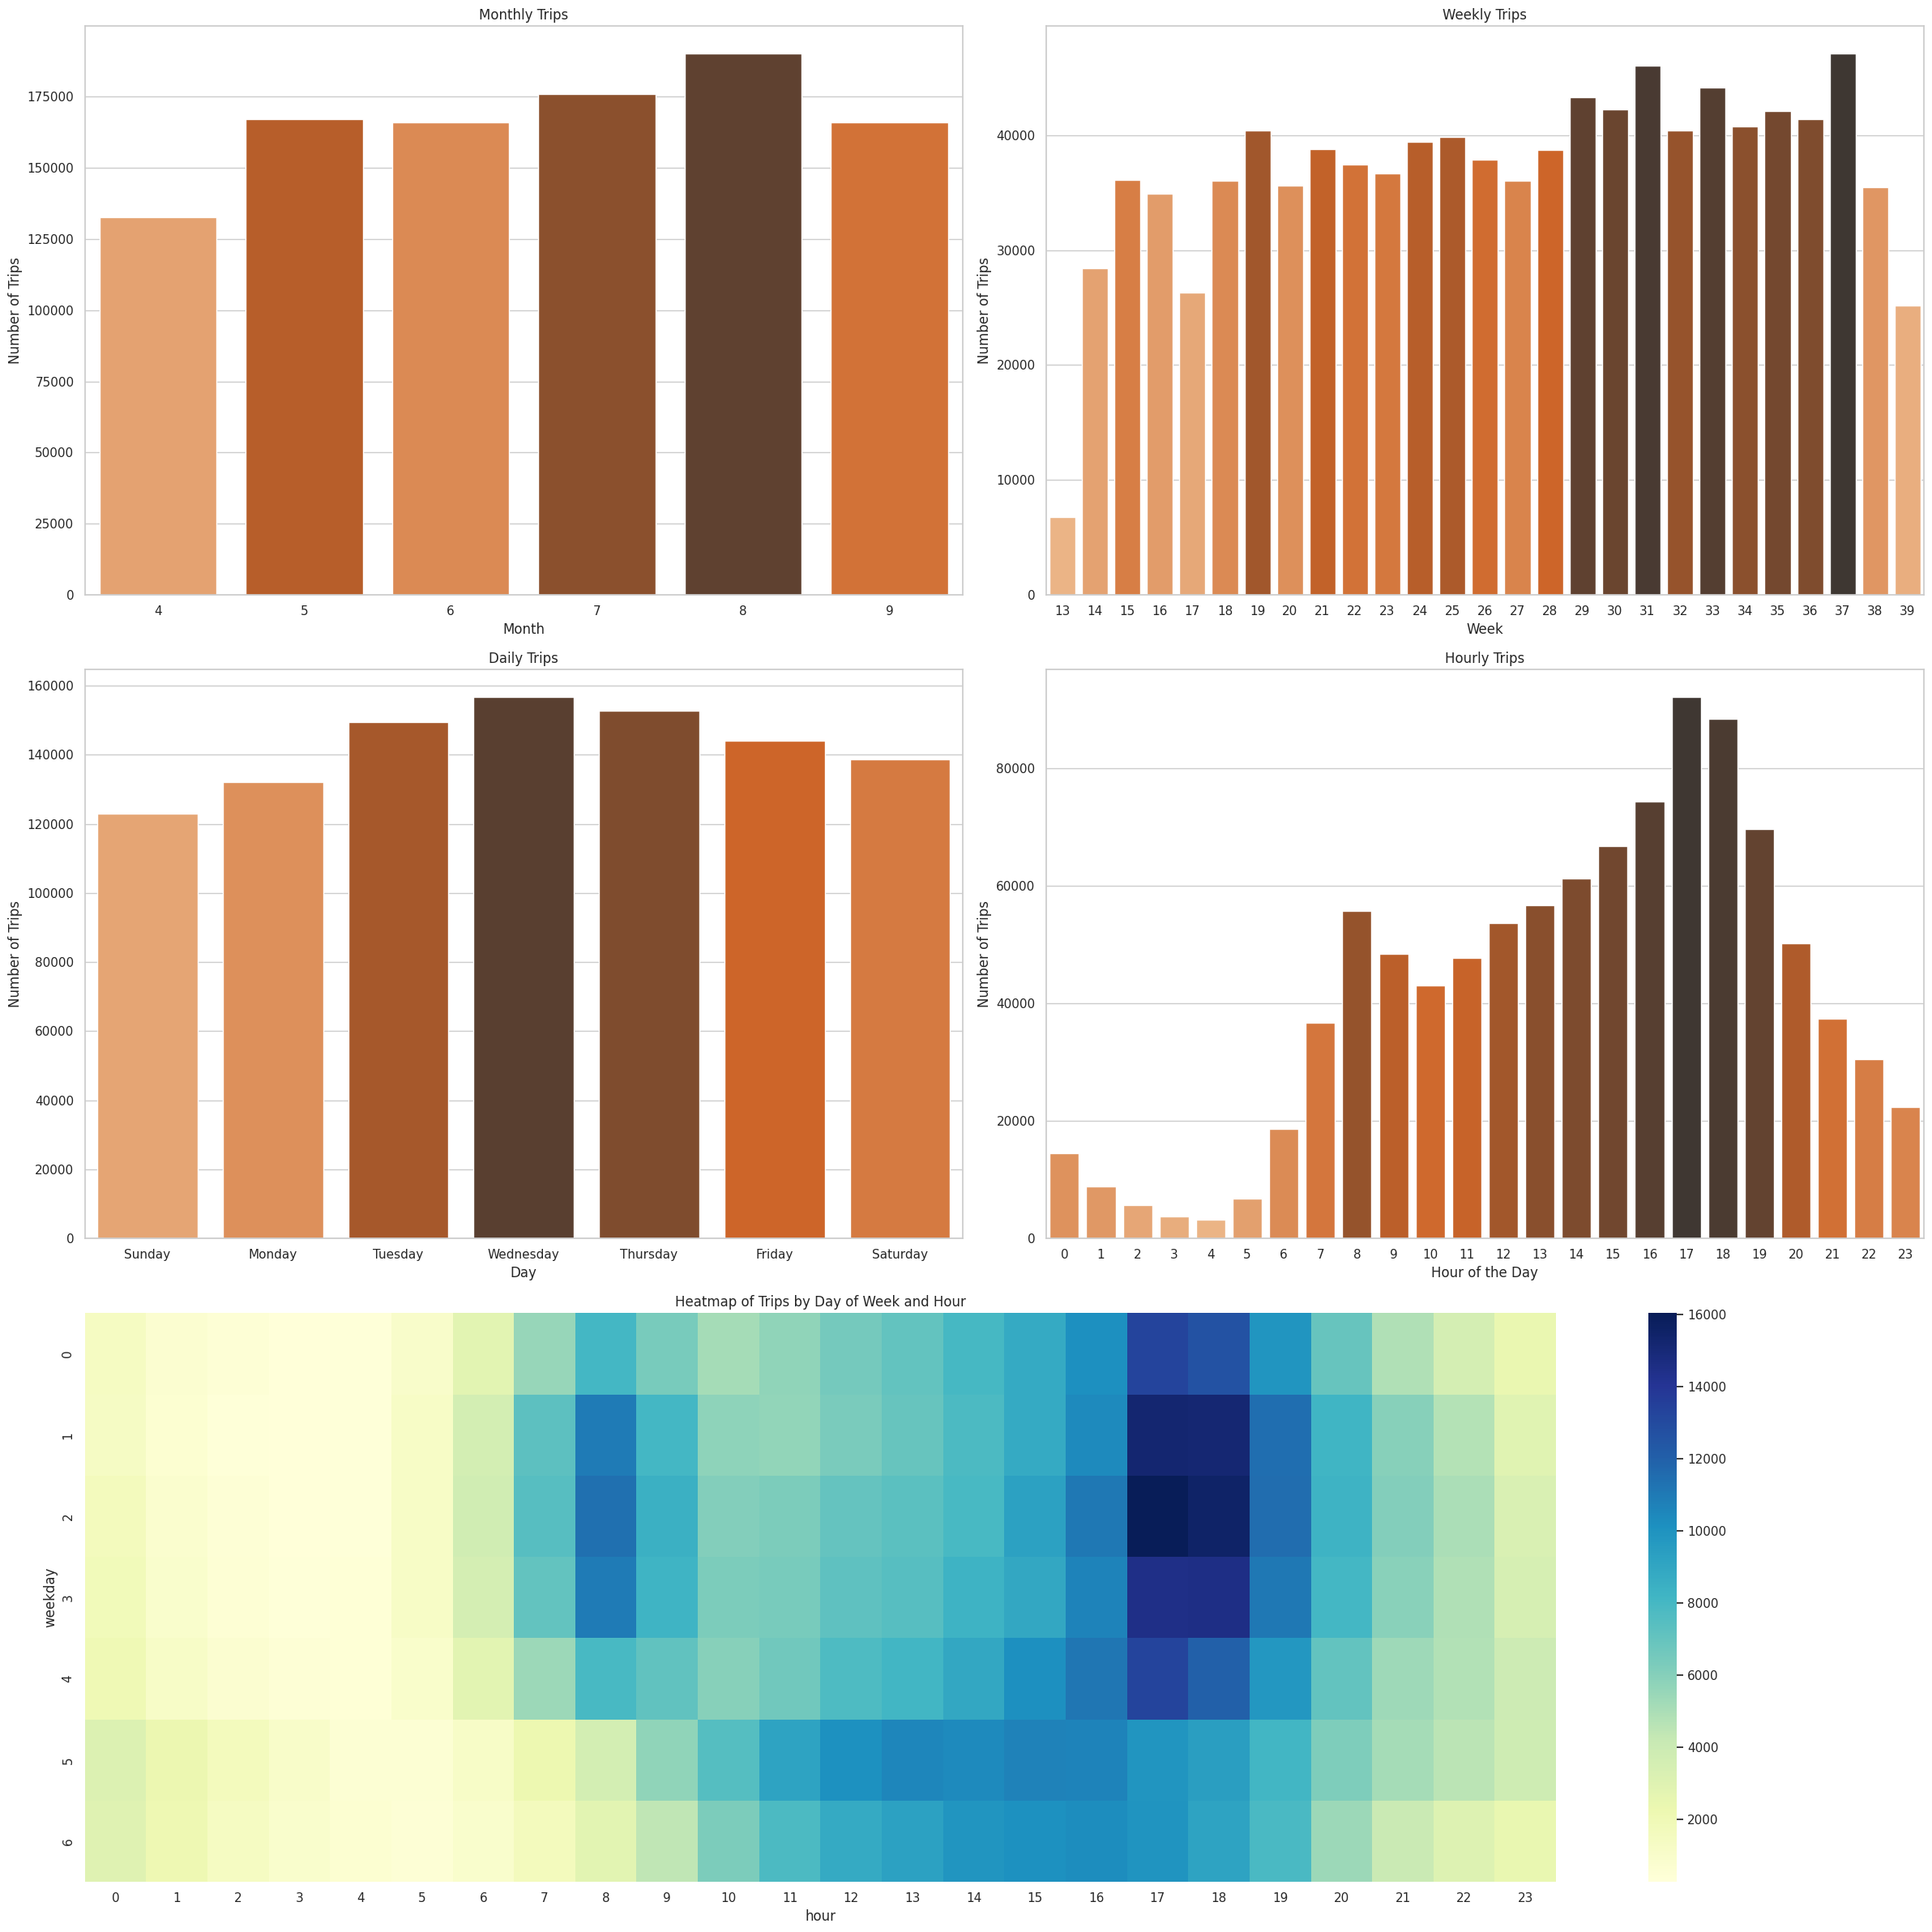

In [5]:
def get_color_palette_and_rank(data, column_name, palette_name):
    pal = sns.color_palette(palette_name, len(data))
    rank = data[column_name].argsort().argsort()
    return np.array(pal)[rank]

# Monthly Summary
monthly_summary = working.groupby('month').size().reset_index()
monthly_summary.columns = ['Month', 'Number of Trips']
monthly_colors = get_color_palette_and_rank(monthly_summary, 'Number of Trips', "Oranges_d")

# Weekly Summary
weekly_summary = working.groupby('week').size().reset_index()
weekly_summary.columns = ['Week', 'Number of Trips']
weekly_colors = get_color_palette_and_rank(weekly_summary, 'Number of Trips', "Oranges_d")

# Daily Summary
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_type = pd.CategoricalDtype(categories=days_order, ordered=True)
working['weekday_name'] = working['weekday_name'].astype(day_type)

ride_counts_by_day = working.groupby('weekday_name').size().reset_index()
ride_counts_by_day.columns = ['Day', 'Number of Trips']
ride_counts_by_day = ride_counts_by_day.sort_values('Day')

daily_colors = get_color_palette_and_rank(ride_counts_by_day, 'Number of Trips', "Oranges_d")

# Hourly Summary
ride_counts_by_hour = working['hour'].value_counts().sort_index().reset_index()
ride_counts_by_hour.columns = ['Hour of the Day', 'Number of Trips']
hourly_colors = get_color_palette_and_rank(ride_counts_by_hour, 'Number of Trips', "Oranges_d")

# Heatmap Data Preparation
heatmap_data = working.groupby(['weekday', 'hour']).size().reset_index(name='trips')
heatmap_data = heatmap_data.pivot("weekday", "hour", "trips")

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(24, 24))

plt.subplot(3, 2, 1)
sns.barplot(x='Month', y='Number of Trips', data=monthly_summary, palette=monthly_colors)
plt.title("Monthly Trips")

plt.subplot(3, 2, 2)
sns.barplot(x='Week', y='Number of Trips', data=weekly_summary, palette=weekly_colors)
plt.title("Weekly Trips")

plt.subplot(3, 2, 3)
sns.barplot(x='Day', y='Number of Trips', data=ride_counts_by_day, palette=daily_colors)
plt.title('Daily Trips')

plt.subplot(3, 2, 4)
sns.barplot(x='Hour of the Day', y='Number of Trips', data=ride_counts_by_hour, palette=hourly_colors)
plt.title('Hourly Trips')

# Heatmap
plt.subplot(3, 2, (5, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title("Heatmap of Trips by Day of Week and Hour")

plt.tight_layout()

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Data Exploration Working/Number of Rides Summary.png')

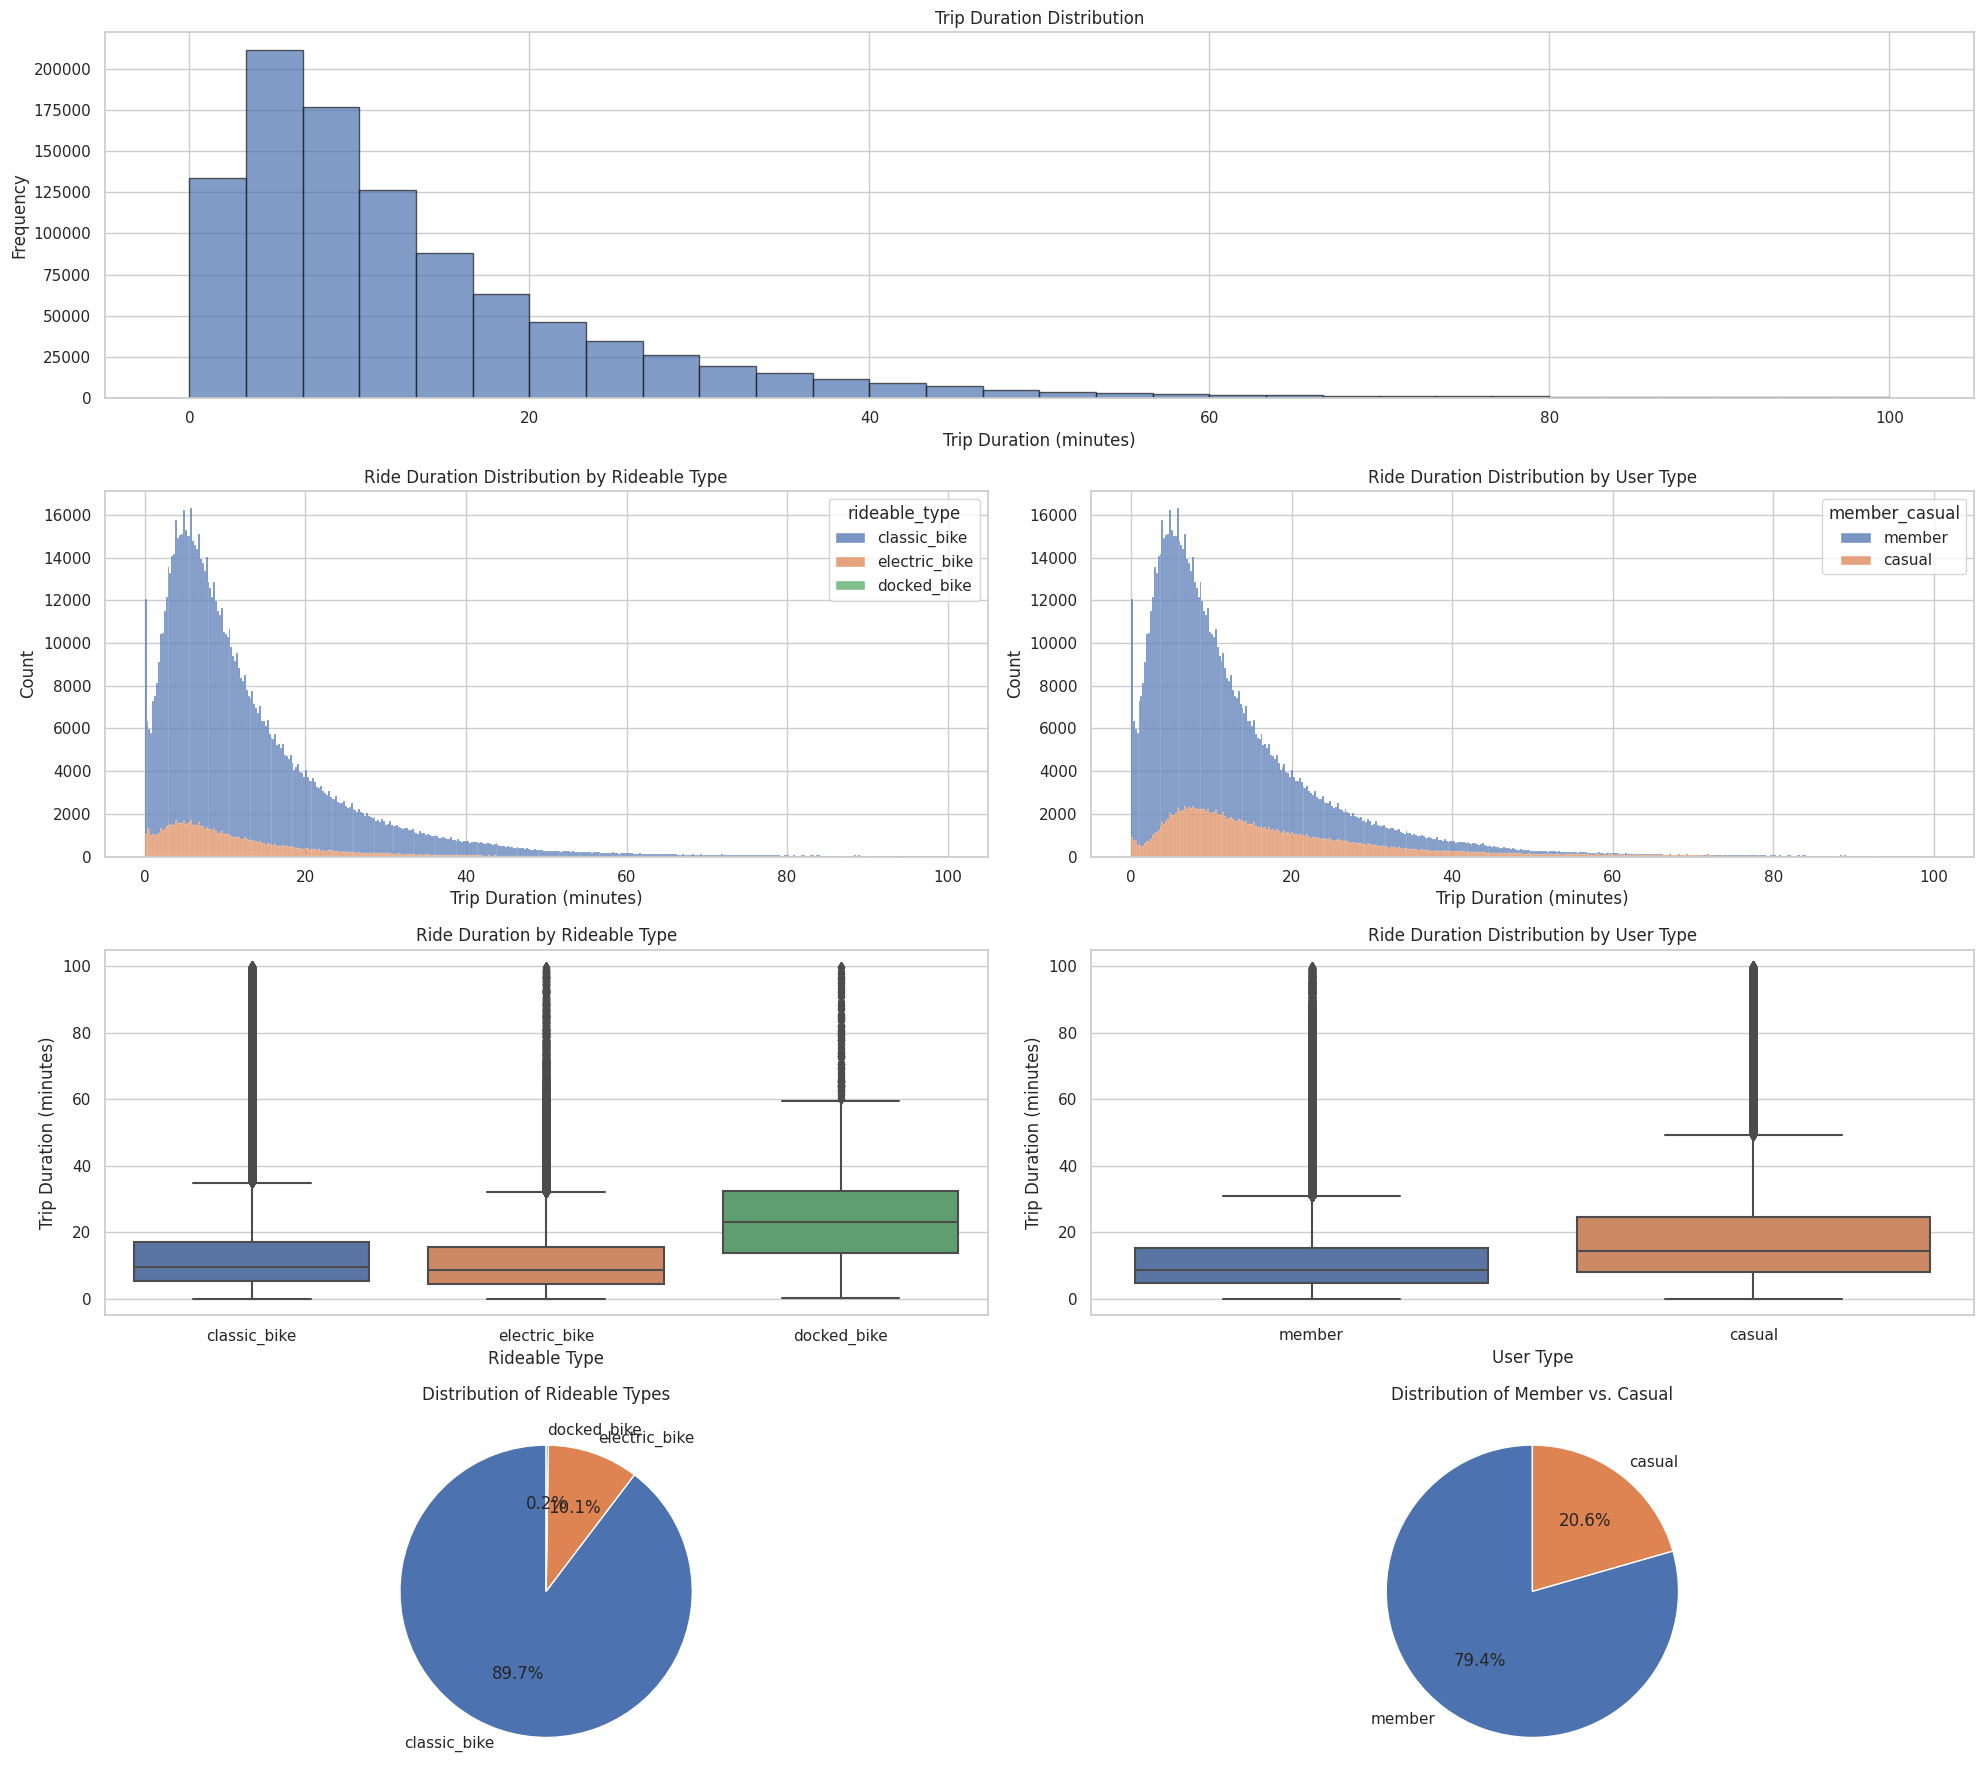

In [6]:
threshold = 100
filtered_df = working[(working['trip_duration_in_minutes'] >= 0) & (working['trip_duration_in_minutes'] <= threshold)]

rideable_counts = working['rideable_type'].value_counts()
member_counts = working['member_casual'].value_counts()

sns.set(style="whitegrid")

# Setting up the figure for subplots
plt.figure(figsize=(20, 18))

# Histogram for Trip Duration Distribution spanning the top row
plt.subplot(4, 2, (1, 2))
plt.hist(filtered_df['trip_duration_in_minutes'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')

# Histogram for Ride Duration by Rideable Type in the second row
plt.subplot(4, 2, 3)
sns.histplot(data=filtered_df, x='trip_duration_in_minutes', hue='rideable_type', multiple="stack")
plt.title('Ride Duration Distribution by Rideable Type')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Count')

# Histogram for Ride Duration by User Type in the second row
plt.subplot(4, 2, 4)
sns.histplot(data=filtered_df, x='trip_duration_in_minutes', hue='member_casual', multiple="stack")
plt.title('Ride Duration Distribution by User Type')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Count')

# Boxplot for Ride Duration by Rideable Type in the second row
plt.subplot(4, 2, 5)
sns.boxplot(data=filtered_df, x='rideable_type', y='trip_duration_in_minutes')
plt.title('Ride Duration by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Trip Duration (minutes)')

# Boxplot for Ride Duration by User Type in the second row
plt.subplot(4, 2, 6)
sns.boxplot(data=filtered_df, x='member_casual', y='trip_duration_in_minutes')
plt.title('Ride Duration Distribution by User Type')
plt.xlabel('User Type')
plt.ylabel('Trip Duration (minutes)')

# Pie chart for Rideable Types in the third row
plt.subplot(4, 2, 7)
plt.pie(rideable_counts, labels=rideable_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Rideable Types")

# Pie chart for Member vs. Casual in the third row
plt.subplot(4, 2, 8)
plt.pie(member_counts, labels=member_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Member vs. Casual")

plt.tight_layout()

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Data Exploration Working/Ride Duration Summary.png')

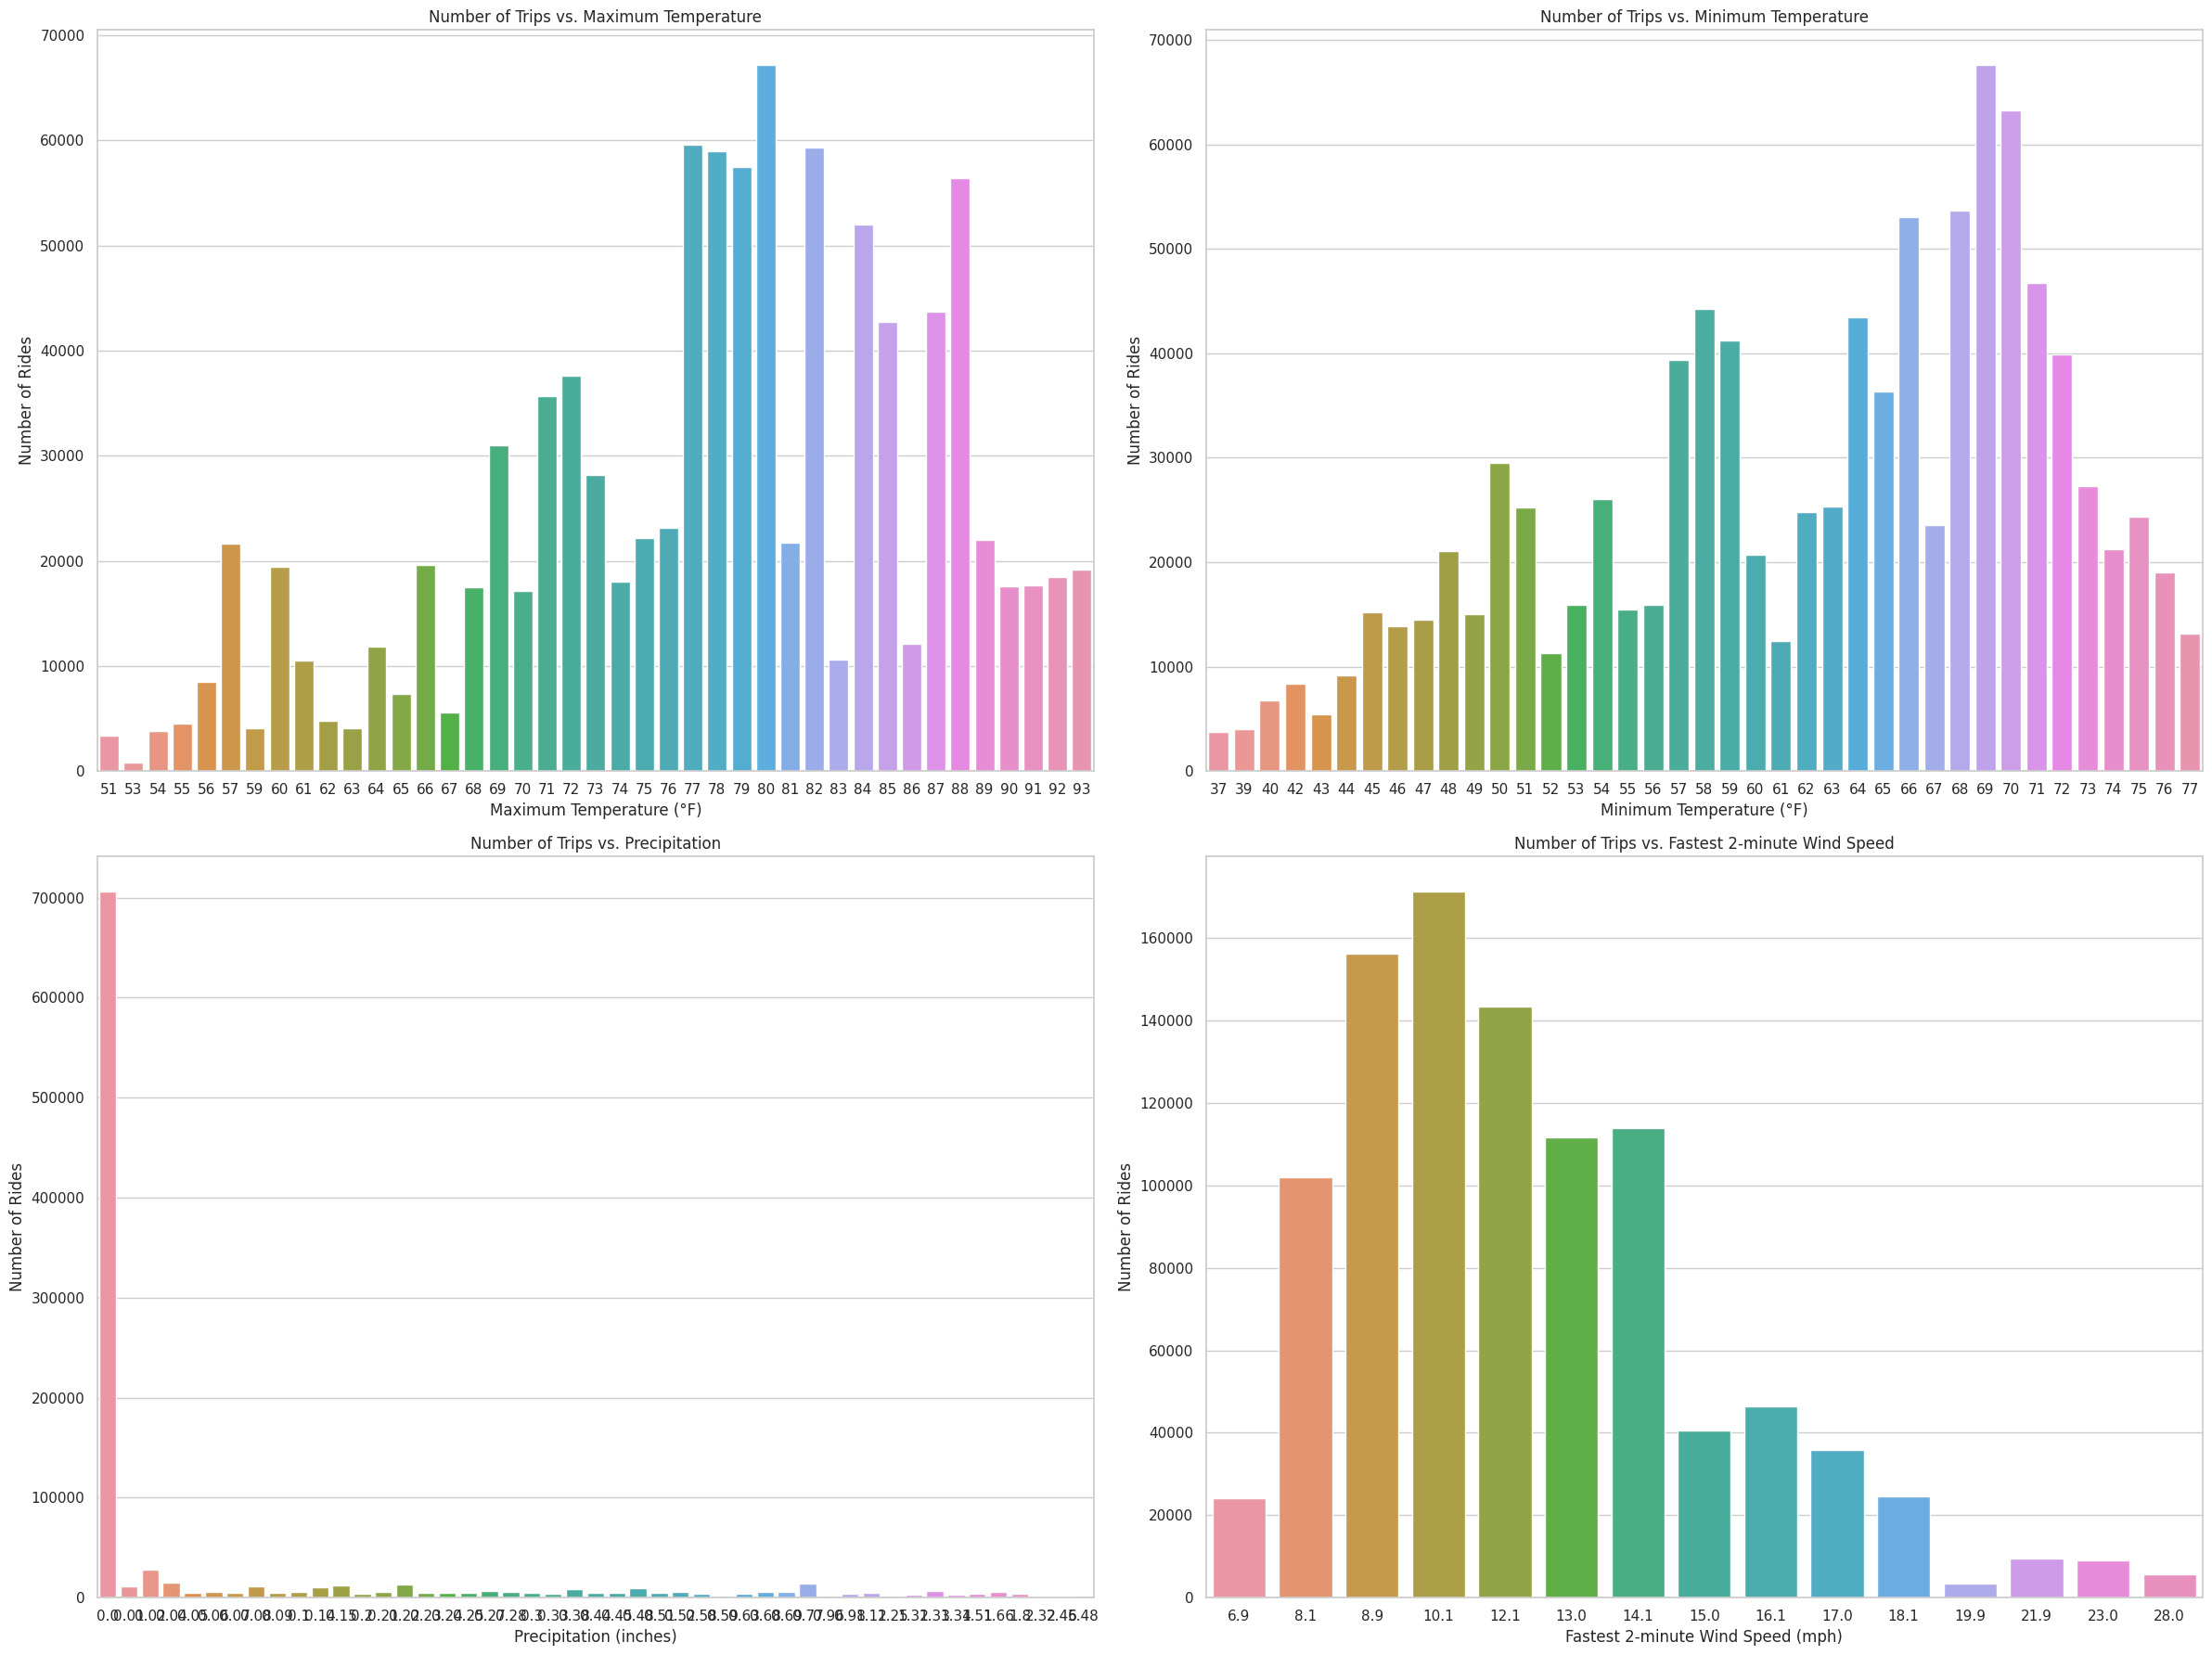

In [7]:
sns.set(style="whitegrid")

plt.figure(figsize=(24, 18))

# Subplot for Number of Trips vs. Maximum Temperature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first subplot
TMAX = working.groupby('TMAX')['ride_id'].count().reset_index()
sns.barplot(data=TMAX, x='TMAX', y='ride_id')
plt.title('Number of Trips vs. Maximum Temperature')
plt.xlabel('Maximum Temperature (°F)')
plt.ylabel('Number of Rides')

# Subplot for Number of Trips vs. Minimum Temperature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, second subplot
TMIN = working.groupby('TMIN')['ride_id'].count().reset_index()
sns.barplot(data=TMIN, x='TMIN', y='ride_id')
plt.title('Number of Trips vs. Minimum Temperature')
plt.xlabel('Minimum Temperature (°F)')
plt.ylabel('Number of Rides')

# Subplot for Number of Trips vs. Precipitation
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third subplot
PRCP = working.groupby('PRCP')['ride_id'].count().reset_index()
sns.barplot(data=PRCP, x='PRCP', y='ride_id')
plt.title('Number of Trips vs. Precipitation')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Number of Rides')

# The fourth subplot is intentionally left empty
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, fourth subplot
WSF2 = working.groupby('WSF2')['ride_id'].count().reset_index()
sns.barplot(data=WSF2, x='WSF2', y='ride_id')
plt.title('Number of Trips vs. Fastest 2-minute Wind Speed')
plt.xlabel('Fastest 2-minute Wind Speed (mph)')
plt.ylabel('Number of Rides')

plt.tight_layout()

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Data Exploration Working/Number of Rides Summary (Weather).png')

In [8]:
# Calculate Drop-Off Popularity and Sort by End Station Name
drop_off_popularity = working.groupby("end_station_name")["ride_id"].size().reset_index(name="drop_off_popularity").sort_values(by="end_station_name")

# Obtain the average coordinates for each end station
station_average_coords = working.groupby('end_station_name').agg({
    'end_lat': 'mean',
    'end_lng': 'mean'
}).reset_index()

# Merge the drop-off popularity counts with their corresponding station coordinates
trips_and_end_coords = pd.merge(drop_off_popularity, station_average_coords, on='end_station_name', how='left')

# Calculate the average location to center the map
average_location = [working['end_lat'].mean(), working['end_lng'].mean()]

# Create a map centered around the average location of all end stations
map_with_trip_markers = folium.Map(location=average_location, zoom_start=13)

# Add bubble markers to the map for each station
for idx, row in trips_and_end_coords.iterrows():
    folium.CircleMarker(
        location=[row['end_lat'], row['end_lng']],
        radius=row['drop_off_popularity'] / 250,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"{row['end_station_name']}: {row['drop_off_popularity']} trips"
    ).add_to(map_with_trip_markers)

map_with_trip_markers

Output hidden; open in https://colab.research.google.com to view.

In [9]:
# Calculate Start-Off Popularity and Sort by Start Station Name
start_off_popularity = working.groupby("start_station_name")["ride_id"].size().reset_index(name="start_off_popularity").sort_values(by="start_station_name")

# Obtain the average coordinates for each start station
station_average_coords = working.groupby('start_station_name').agg({
    'start_lat': 'mean',
    'start_lng': 'mean'
}).reset_index()

# Merge the start-off popularity counts with their corresponding station coordinates
trips_and_start_coords = pd.merge(start_off_popularity, station_average_coords, on='start_station_name', how='left')

# Calculate the average location to center the map
average_location = [working['start_lat'].mean(), working['start_lng'].mean()]

# Create a map centered around the average location of all start stations
map_with_start_trip_markers = folium.Map(location=average_location, zoom_start=13)

# Add bubble markers to the map for each station
for idx, row in trips_and_start_coords.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=row['start_off_popularity'] / 250,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        popup=f"{row['start_station_name']}: {row['start_off_popularity']} trips"
    ).add_to(map_with_start_trip_markers)

map_with_start_trip_markers

Output hidden; open in https://colab.research.google.com to view.

### 3. Examine biases in labels, if any.

In [10]:
# Frequency of each end station
station_counts = working['end_station_name'].value_counts()

# Top 10 and Bottom 10 Stations
top_stations = station_counts.head(10)
bottom_stations = station_counts.tail(10)

# Quantile Analysis
quantiles = station_counts.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

# Cumulative Distribution Plot
cumulative_distribution = station_counts.sort_values(ascending=False).cumsum() / station_counts.sum()

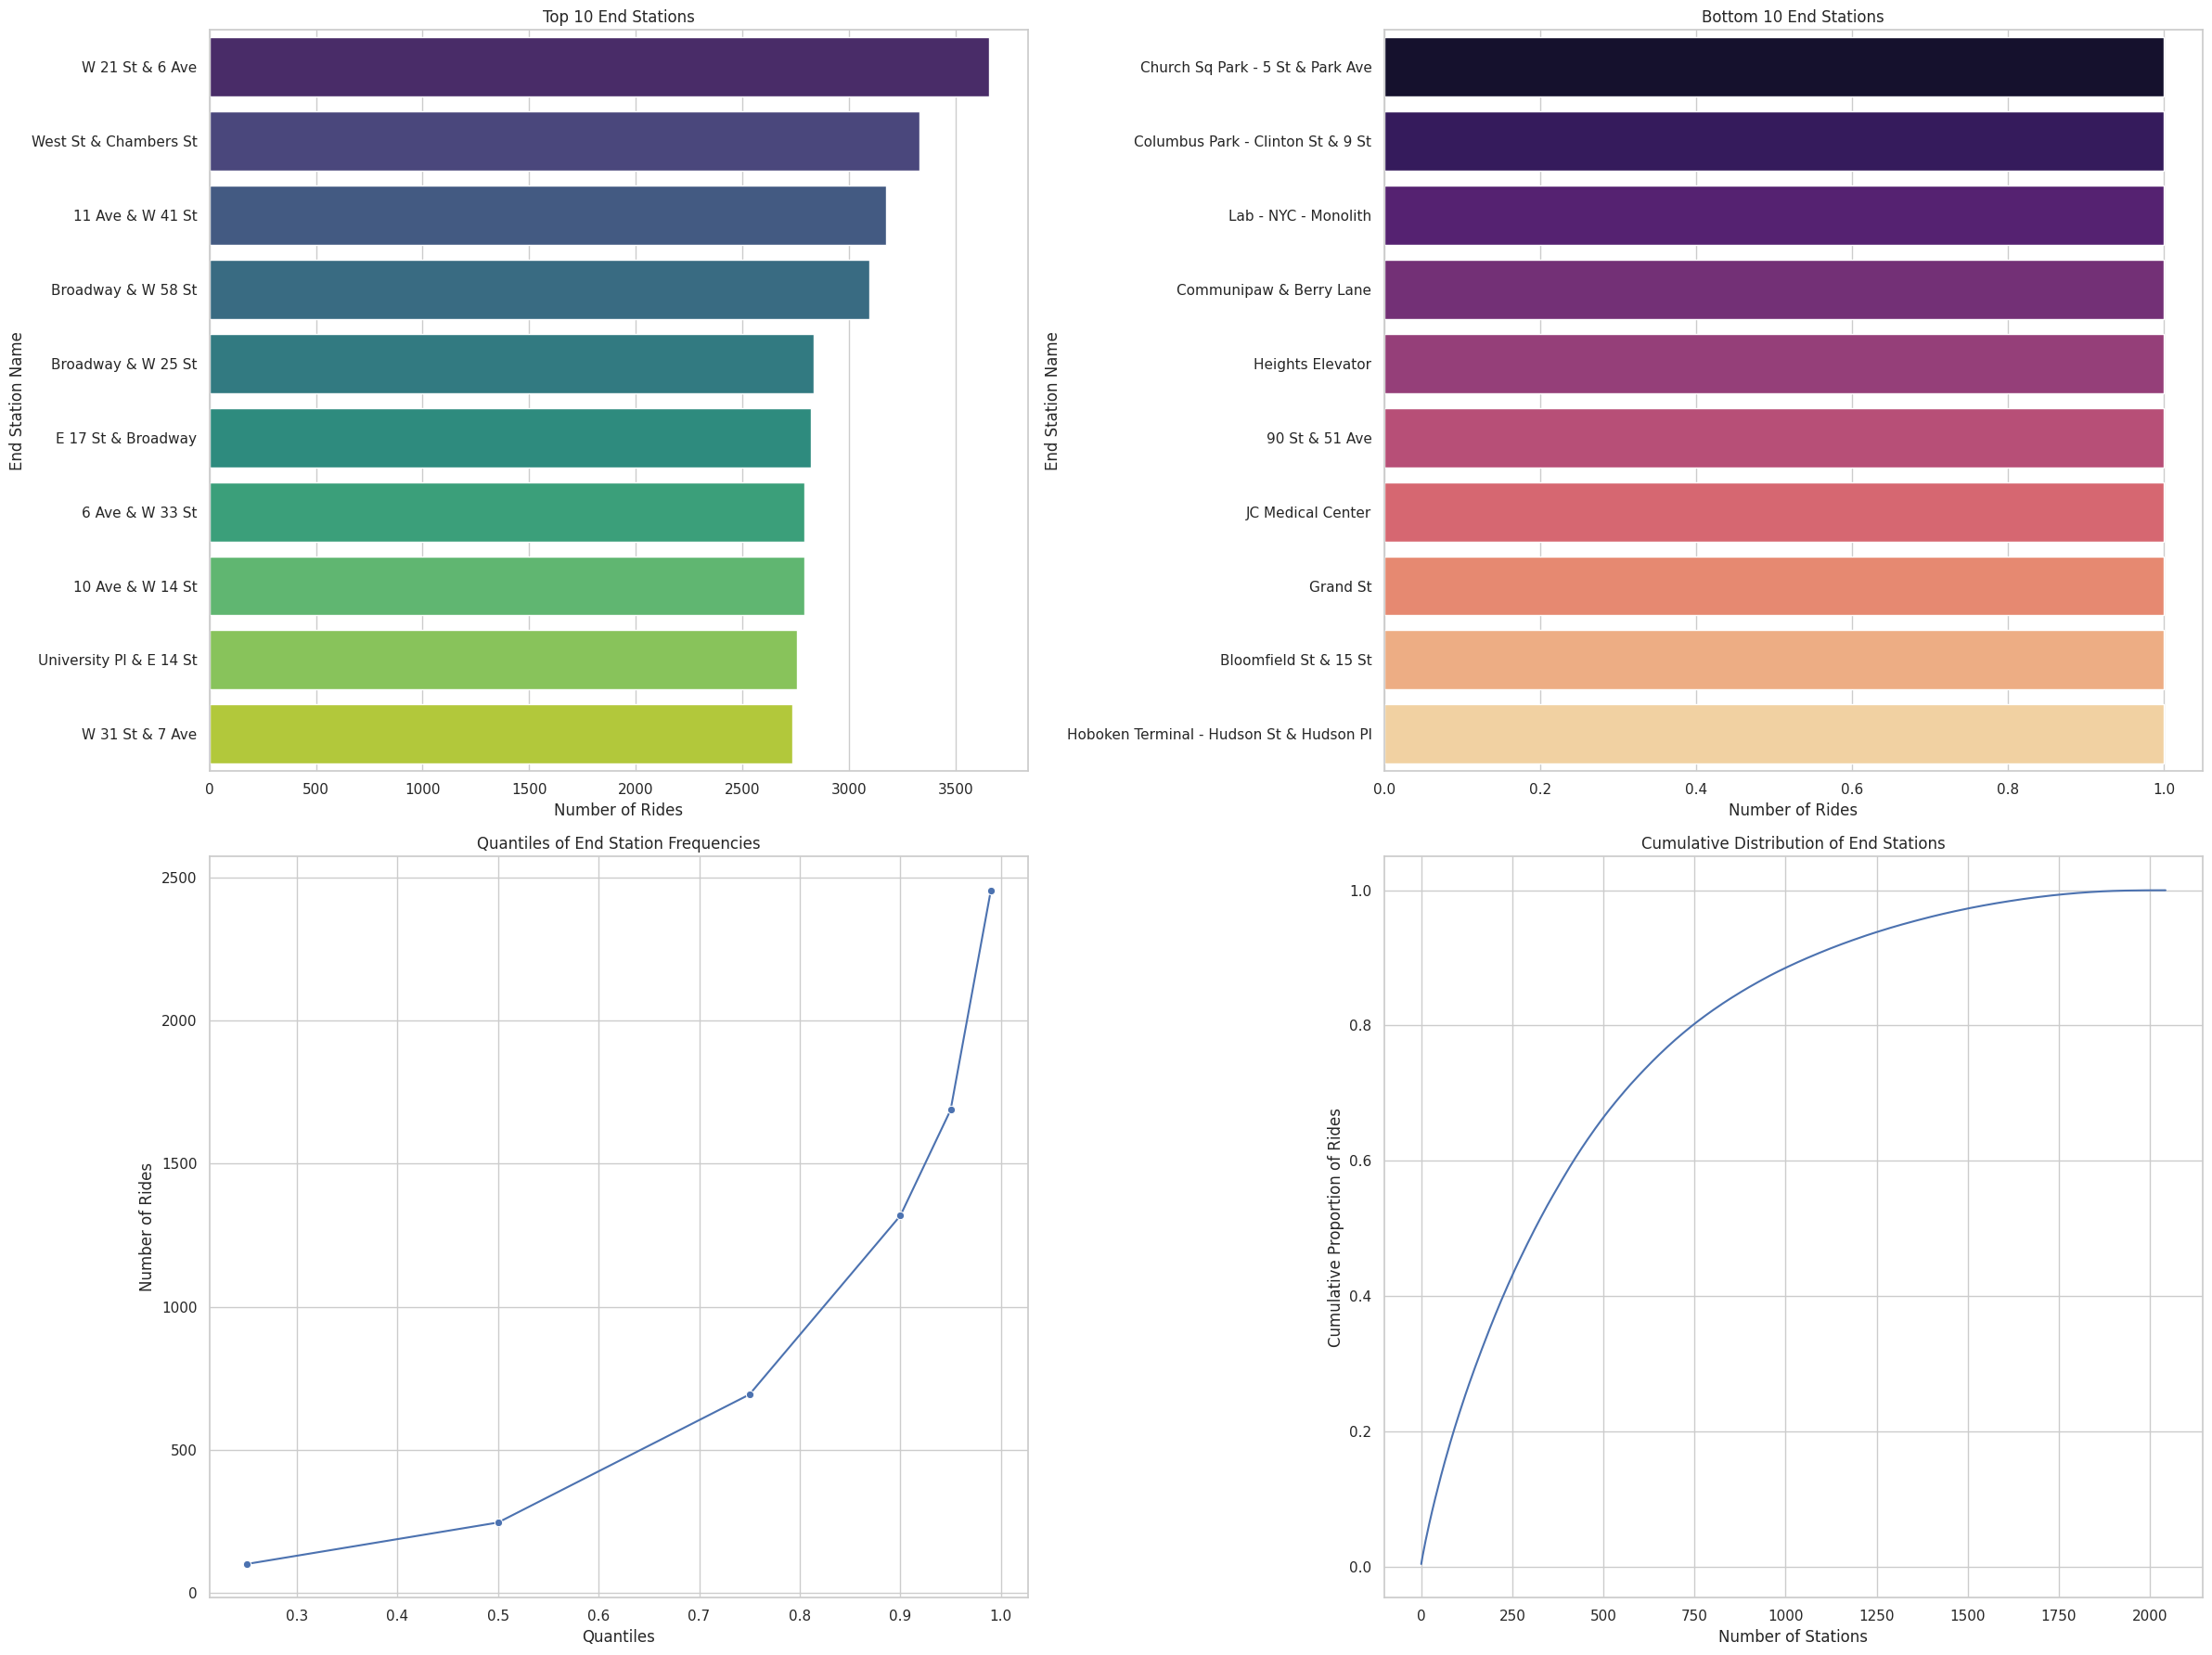

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 18))

# Top 10 Stations Plot
sns.barplot(x=top_stations.values, y=top_stations.index, palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title('Top 10 End Stations')
axes[0, 0].set_xlabel('Number of Rides')
axes[0, 0].set_ylabel('End Station Name')

# Bottom 10 Stations Plot
sns.barplot(x=bottom_stations.values, y=bottom_stations.index, palette="magma", ax=axes[0, 1])
axes[0, 1].set_title('Bottom 10 End Stations')
axes[0, 1].set_xlabel('Number of Rides')
axes[0, 1].set_ylabel('End Station Name')

# Quantile Plot
sns.lineplot(x=quantiles.index, y=quantiles.values, marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Quantiles of End Station Frequencies')
axes[1, 0].set_xlabel('Quantiles')
axes[1, 0].set_ylabel('Number of Rides')

# Cumulative Distribution Plot
sns.lineplot(x=range(len(cumulative_distribution)), y=cumulative_distribution, ax=axes[1, 1])
axes[1, 1].set_title('Cumulative Distribution of End Stations')
axes[1, 1].set_xlabel('Number of Stations')
axes[1, 1].set_ylabel('Cumulative Proportion of Rides')

plt.tight_layout()

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Data Exploration Working/Rides Descriptive Statistics.png')

### 4. Address and discuss issues related to missing, imbalanced, or sparse data.

  ***Missing Data***

- **Status**: Handled in the initial data extraction phase (`0_DataExtraction.ipynb` notebook).
- **Details**: Appropriate techniques were applied to address any missing values in the dataset, ensuring a complete dataset for analysis and modeling.

  ***Sparsity Analysis***

1. **Rideable Type (`rideable_type`):**
   - This feature was one-hot encoded to transform it into a format suitable for machine learning algorithms.
   - **Sparsity:**
     - `classic_bike`: Approximately 10.32% of the data points are non-zero.
     - `docked_bike`: Approximately 99.76% of the data points are non-zero.
     - `electric_bike`: Approximately 89.92% of the data points are non-zero.
   - **Interpretation**: The high sparsity for `docked_bike` suggests it's rarely used, whereas `electric_bike` appears to be the most commonly used type, followed by `classic_bike`.

2. **Start Station Name (`start_station_name`):**
   - After one-hot encoding, this feature represents each station as a separate binary column.
   - **Overall Sparsity**: Approximately 99.95%.
   - **Interpretation**: The extremely high level of sparsity indicates that most stations are infrequently used as start points in individual rides, which aligns with the large number of stations.

In [12]:
# Sparse Data
rideable_type_encoded = pd.get_dummies(working['rideable_type'])
sparsity = 1.0 - (rideable_type_encoded.astype(bool).sum(axis=0) / len(rideable_type_encoded))
print("\nSparsity in One-Hot Encoded 'rideable_type':\n", sparsity)


start_station_encoded = pd.get_dummies(working['start_station_name'])
sparsity = (start_station_encoded == 0).mean().mean()
print("\nOverall Sparsity in One-Hot Encoded 'start_station_name':", sparsity)


Sparsity in One-Hot Encoded 'rideable_type':
 classic_bike     0.103221
docked_bike      0.997579
electric_bike    0.899200
dtype: float64

Overall Sparsity in One-Hot Encoded 'start_station_name': 0.9995051954477981
